# Installs

In [37]:
!pip install rouge-score
!pip uninstall -y wandb

# Libraries

In [38]:
import re
import ast
import torch
import tokenizers
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer, MT5ForConditionalGeneration, MT5Tokenizer, EarlyStoppingCallback

# Reading Data

In [39]:
df_arcd1 = pd.read_excel('/kaggle/input/arcd-dataset/arcd-train.xlsx')
df_arcd2 = pd.read_excel('/kaggle/input/arcd-dataset/arcd-test.xlsx')
df_arcd = pd.concat([df_arcd1, df_arcd2], ignore_index=True)

print("arcd data loaded")

arcd data loaded


# Data Overview

In [40]:
df_arcd.head()

,id,question,context,answers,c_id
0,969331847966,- من هو جمال أحمد حمزة خاشقجي؟,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'صحفي وإعلامي', 'answer_start': 73}]",0
1,115150665555,- متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'حمزة خاشقجي (13 أكتوبر 1958، المدين...,0
2,74212080718,- في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'المدينة المنورة', 'answer_start': 39}]",0
3,465699296586,- في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'واشنطن بوست', 'answer_start': 224}]",1
4,564177542570,- كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'وُصف في الصحف وأجهزة الاعلام العالم...,1


In [41]:
df_arcd.shape

(1395, 5)

In [42]:
df_arcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1395 non-null   int64 
 1   question  1395 non-null   object
 2   context   1395 non-null   object
 3   answers   1395 non-null   object
 4   c_id      1395 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 54.6+ KB


# Removing id column

In [43]:
df_arcd.drop('id', axis=1, inplace=True)

In [44]:
df_arcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1395 non-null   object
 1   context   1395 non-null   object
 2   answers   1395 non-null   object
 3   c_id      1395 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 43.7+ KB


In [45]:
df_arcd.head(10)

,question,context,answers,c_id
0,- من هو جمال أحمد حمزة خاشقجي؟,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'صحفي وإعلامي', 'answer_start': 73}]",0
1,- متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'حمزة خاشقجي (13 أكتوبر 1958، المدين...,0
2,- في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'المدينة المنورة', 'answer_start': 39}]",0
3,- في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'واشنطن بوست', 'answer_start': 224}]",1
4,- كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'وُصف في الصحف وأجهزة الاعلام العالم...,1
5,- في أي منصب شغل في الجريدة؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'وتقلّد منصب مستشار،', 'answer_start...",1
6,- متى غادر خاشقجي السعودية؟ ال,غادر خاشقجي السعودية في سبتمبر 2017، وكتب بعد ...,"[{'text': 'في سبتمبر 2017،', 'answer_start': 21}]",2
7,- لمن ينتقده في مقالاته الإخبارية؟ ال,غادر خاشقجي السعودية في سبتمبر 2017، وكتب بعد ...,"[{'text': 'الحكومة السعودية.', 'answer_start':...",2
8,- لمن انتقد خاشقجي بشدة في مقالاته الإخبارية؟ ال,غادر خاشقجي السعودية في سبتمبر 2017، وكتب بعد ...,[{'text': 'ولي العهد السعودي محمد بن سلمان، وا...,2
9,- أي دولة هي أكبر دولة في الشرق الأوسط؟ ال,السعودية أو (رسميًا: المملكة العربية السعودية)...,"[{'text': 'المملكة العربية السعودية)', 'answer...",3


# Text Preprocessing

## text cleaning functions

### Normalization

In [46]:
def remove_diacritics(text):
    # remove diacritics from the text as it may confuse the model
    return re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)


### Text cleaning

In [47]:
def remove_non_arabic(text):
    # Remove non-Arabic characters, keeping essential punctuation
    text = re.sub(r'[^\u0600-\u06FF\s؟]', '', text)
    return text

In [48]:
def remove_punk(text):
    # Remove punctuation
    arabic_punctuation = r'[،؛…!"#$%&\'()*+,-./:;<=>@^_`{|}~]'
    text = re.sub(arabic_punctuation, '', text)
    return text

In [49]:
def remove_extra_spaces(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [50]:
def remove_alef_variations(text):
    text = re.sub(r'[إأٱآ]', 'ا', text)
    return text

### Handling numbers

In [51]:
def handle_numbers(text, replace_with=None):
    if replace_with:
        text = re.sub(r'\d+', replace_with, text)
    else:
        text = re.sub(r'\d+', '', text)
    return text

## Stop word removal

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
stop_words = set(stopwords.words('arabic'))
print(stop_words)

{'حزيران', 'إياك', 'ما أفعله', 'أو', 'تعلَّم', 'هَذا', 'سابع', 'أمامك', 'حدَث', 'كيفما', 'من', 'حبذا', 'أنتِ', 'عشرين', 'رابع', 'حجا', 'هيّا', 'صبرا', 'إليكن', 'ترك', 'أصبح', 'حاي', 'أف', 'بمن', 'ثمة', 'هاته', 'يا', 'ثمان', 'شَتَّانَ', 'كأين', 'أيا', 'ذواتي', 'مافتئ', 'أفعل به', 'رأى', 'رويدك', 'طفق', 'تِي', 'أربعمئة', 'حين', 'أكثر', 'فلس', 'ث', 'أ', 'أخبر', 'أمامكَ', 'ظ', 'هَيْهات', 'أجل', 'د', 'ا', 'أخٌ', 'كثيرا', 'خاصة', 'عسى', 'ذه', 'لكما', 'هللة', 'هنا', 'دولار', 'إياه', 'لدن', 'تسع', 'بنا', 'أنبأ', 'إياكم', 'قطّ', 'ين', 'ق', 'حمو', 'أيار', 'وإذ', 'عامة', 'نَخْ', 'عشرة', 'آنفا', 'أربعة', 'خمس', 'دال', 'كن', 'اللتين', 'قلما', 'لكيلا', 'إي', 'خمسمئة', 'أل', 'فاء', 'راح', 'حيث', 'ذ', 'ثمّة', 'ممن', 'آه', 'ح', 'اربعون', 'هل', 'تين', 'ابتدأ', 'أعطى', 'إياهما', 'أربعمائة', 'ستة', 'أفٍّ', 'ن', 'أنتم', 'تسعة', 'ما', 'فبراير', 'ذين', 'هاك', 'معاذ', 'حار', 'إياهم', 'م', 'ي', 'رُبَّ', 'والذين', 'شتان', 'اللتان', 'ثلاثة', 'ذانك', 'لك', 'اثنان', 'راء', 'كلاهما', 'تلك', 'وَيْ', 'دونك', 'أضحى', 

In [54]:
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Sentence splitting

In [55]:
def split_sentences(text):
    sentences = re.split(r'[؟.!؟]', text)
    # Remove empty sentences and strip spaces
    return [sentence.strip() for sentence in sentences if sentence.strip()]

## Remove additional spaces between letters

In [56]:
def fix_arabic_spacing(text):
    # Reconnect ا to the previous word if it is fully isolated
    text = re.sub(r'(\S)\s+ا\s+', r'\1ا ', text)

    # Reconnect أ and ي to the next word if they are fully isolated
    text = re.sub(r'\s+أ\s+(\S)', r' أ\1', text)
    text = re.sub(r'\s+ي\s+(\S)', r' ي\1', text)

    # Normalize spaces (remove extra spaces)
    text = remove_extra_spaces(text)

    return text

![image.png](attachment:image.png)

# Tokenization

In [57]:
!pip install SentencePiece 
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


### Selected tokenizer

In [58]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

## Apply Functions on the text

In [59]:
df_arcd.head(10)


,question,context,answers,c_id
0,- من هو جمال أحمد حمزة خاشقجي؟,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'صحفي وإعلامي', 'answer_start': 73}]",0
1,- متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'حمزة خاشقجي (13 أكتوبر 1958، المدين...,0
2,- في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'المدينة المنورة', 'answer_start': 39}]",0
3,- في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'واشنطن بوست', 'answer_start': 224}]",1
4,- كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'وُصف في الصحف وأجهزة الاعلام العالم...,1
5,- في أي منصب شغل في الجريدة؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'وتقلّد منصب مستشار،', 'answer_start...",1
6,- متى غادر خاشقجي السعودية؟ ال,غادر خاشقجي السعودية في سبتمبر 2017، وكتب بعد ...,"[{'text': 'في سبتمبر 2017،', 'answer_start': 21}]",2
7,- لمن ينتقده في مقالاته الإخبارية؟ ال,غادر خاشقجي السعودية في سبتمبر 2017، وكتب بعد ...,"[{'text': 'الحكومة السعودية.', 'answer_start':...",2
8,- لمن انتقد خاشقجي بشدة في مقالاته الإخبارية؟ ال,غادر خاشقجي السعودية في سبتمبر 2017، وكتب بعد ...,[{'text': 'ولي العهد السعودي محمد بن سلمان، وا...,2
9,- أي دولة هي أكبر دولة في الشرق الأوسط؟ ال,السعودية أو (رسميًا: المملكة العربية السعودية)...,"[{'text': 'المملكة العربية السعودية)', 'answer...",3


### Questions column

In [60]:
df_arcd['processed_question'] = df_arcd['question'].apply(remove_diacritics).apply(remove_punk).apply(remove_extra_spaces)

* i tried to apply text clean function but i think it made some question not understandable

In [61]:
df_arcd['processed_question'].head(10)

0                      من هو جمال أحمد حمزة خاشقجي؟
1           متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال
2         في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال
3      في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال
4     كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال
5                     في أي منصب شغل في الجريدة؟ ال
6                      متى غادر خاشقجي السعودية؟ ال
7               لمن ينتقده في مقالاته الإخبارية؟ ال
8    لمن انتقد خاشقجي بشدة في مقالاته الإخبارية؟ ال
9          أي دولة هي أكبر دولة في الشرق الأوسط؟ ال
Name: processed_question, dtype: object

### Context column

In [62]:
# remove punctuation from words
df_arcd['processed_context'] = df_arcd['context'].apply(remove_punk).apply(remove_diacritics).apply(remove_extra_spaces)

In [63]:
df_arcd['processed_context'][df_arcd['c_id'] == 55].tolist()[0]

'شيرين بنت محيميد 8 أكتوبر 1980 مغنية مصرية ولدت في [حوش بيتنا]] بدأت مشوارها الفني أوائل عام 2002 بأغنية زغرطي يا انشراح الي قاي احسن من الي ر ولكنها لم تكن أول أغانيها حيث ظهرت مع المطرب محمد محي في دويتو غنائي بعنوان بحبك في عام 2000 و كانت الأغنية ضمن ألبوم صورة و دمعة للفنان محمد محيي و لكن انطلاقتها الحقيقية كانت مع تامر حسني الذي كان وجه جديد أيضا في ألبوم غنائي مشترك بعنوان فري ميكس 3 في صيف عام 2002 كما أدت دور تمثيلي للسينما مع أحمد حلمي في فيلم ميدو مشاكل كانت شركة فري ميوزيك لصاحبها نصر محروس أول من أنتج لها غير أنه ونتيجة لبعض الخلافات بين الإثنين تم فسخ العقد بينهما تزوجت شيرين من الملحن والموزع الموسيقي محمد مصطفى ولها ابنتين منه هما مريم وهناء غير أنها انفصلت عنه بعد زواج استمر لمدة 5 سنوات حصلت شيرين على العديد من الجوائز المحلية والعربية خلال مسيرتها الفنية منها الموريكس دور 5 تكريمات كافضل مطربة عربية عام 2011 و 2012 و 2014 و 2017 و 2018 وحصلت على 3 جوائز من الميما ميوزيك اورد كافضل فنانه عربية وأفضل البوم انا كتير وأفضل كليب كلى ملكك عام 2015 وايضا فازت ب 3 جوائز من

### Answers column

In [64]:
def extract_text(data):
    if isinstance(data, str):  # If data is a string, convert it to a list
        try:
            data = ast.literal_eval(data)  # Convert string to actual list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None

    if isinstance(data, list) and data:  # Check if it's a valid non-empty list
        first_item = data[0]  # Access the first dictionary
        if isinstance(first_item, dict):  # Ensure it's a dictionary
            return first_item.get('text', None)  # Get the 'text' value or None if not found
    return None

In [65]:
df_arcd['processed_answers'] = df_arcd['answers'].apply(extract_text)

In [66]:
df_arcd['processed_answers'] = df_arcd['processed_answers'].apply(remove_diacritics).apply(remove_extra_spaces).apply(remove_punk)

In [67]:
df_arcd.head()

,question,context,answers,c_id,processed_question,processed_context,processed_answers
0,- من هو جمال أحمد حمزة خاشقجي؟,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'صحفي وإعلامي', 'answer_start': 73}]",0,من هو جمال أحمد حمزة خاشقجي؟,جمال أحمد حمزة خاشقجي 13 أكتوبر 1958 المدينة ا...,صحفي وإعلامي
1,- متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'حمزة خاشقجي (13 أكتوبر 1958، المدين...,0,متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال,جمال أحمد حمزة خاشقجي 13 أكتوبر 1958 المدينة ا...,حمزة خاشقجي 13 أكتوبر 1958 المدينة المنورة 2 ...
2,- في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'المدينة المنورة', 'answer_start': 39}]",0,في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال,جمال أحمد حمزة خاشقجي 13 أكتوبر 1958 المدينة ا...,المدينة المنورة
3,- في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'واشنطن بوست', 'answer_start': 224}]",1,في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال,جمال أحمد حمزة خاشقجي 13 أكتوبر 1958 المدينة ا...,واشنطن بوست
4,- كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'وُصف في الصحف وأجهزة الاعلام العالم...,1,كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال,جمال أحمد حمزة خاشقجي 13 أكتوبر 1958 المدينة ا...,وصف في الصحف وأجهزة الاعلام العالمية بأنه وفي ...


In [68]:
df_arcd.to_excel("arcd_data_processed.xlsx", index=False, engine="openpyxl")  # Save as Excel

# Prepare the data for Train

## tokenizer

In [69]:
tokenizer = T5Tokenizer.from_pretrained("/kaggle/input/arat5-tokenizer/pytorch/default/1")

### T5 preparation

In [70]:
def preprocess_dataset(dataset):
    preprocessed_data = []
    skip_counter = 0
    answer_skiped_counter = 0
    for example in dataset:
        
        # Skip empty examples
        if not example["processed_context"] or not example["processed_question"] or not example["processed_answers"]:
            skip_counter += 1
            continue

        # Tokenize the input (context)
        inputs = tokenizer(
            example["processed_context"],
            max_length=256,
            truncation=True,
            padding="max_length",
        )

        # # Ensure answers are not empty and get the first answer
        # if isinstance(example["processed_answers"], list) and example["processed_answers"]:
        #     answer_text = example["processed_answers"][0]
        # else:
        #     answer_skiped_counter += 1
        #     answer_text = ""
            
        # answer_text = example["processed_answers"][0] if isinstance(example["processed_answers"], list) and example["processed_answers"] else ""
        # answer_text = example["processed_answers"]
        # answer_text = ""
        
        # Combine question and answer for label (question generation + answer)
        question_answer_text = example["processed_question"]

        # Tokenize the target (question)
        labels = tokenizer(
            question_answer_text,
            max_length=128,
            truncation=True,
            padding="max_length",
        )

        # Append preprocessed data
        preprocessed_data.append({
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels["input_ids"], dtype=torch.long),
        })
        
    print(skip_counter , " skiped due to empty")
    print(answer_skiped_counter , " answers skiped")
    return preprocessed_data


![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [71]:
# Split by context_id to avoid data leakage
context_ids = df_arcd["c_id"].unique()
train_ids, test_ids = train_test_split(context_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Create splits
train_data = df_arcd[df_arcd["c_id"].isin(train_ids)].to_dict("records")
val_data = df_arcd[df_arcd["c_id"].isin(val_ids)].to_dict("records")
test_data = df_arcd[df_arcd["c_id"].isin(test_ids)].to_dict("records")

# Preprocess each split
train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)


print("total rows after processing ", len(train_processed) + len(val_processed) + len(test_processed))

1  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
0  skiped due to empty
0  answers skiped
total rows after processing  1394


# Model

### Select a model

In [82]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/arat5_base_final/pytorch/default/1")

### Change the size of the model to accept the tokens

In [83]:
# Resize the model's embedding layer
model.resize_token_embeddings(len(tokenizer))

# Verify the new vocabulary size
print("New model vocabulary size:", model.config.vocab_size)

New model vocabulary size: 110100


## check on data

In [74]:
def check_tensor_dataset(dataset, name="Dataset"):
    print(f"Checking {name} for NaN or Inf values...")
    for i in range(len(dataset)):
        sample = dataset[i]  # Get one example (which is a dictionary)

        for key in ["input_ids", "attention_mask", "labels"]:
            if key in sample:
                tensor = sample[key]  # Extract tensor for this key

                if torch.isnan(tensor).any():
                    print(f"NaN found in {key} at index {i}")
                if torch.isinf(tensor).any():
                    print(f"Inf found in {key} at index {i}")

    print(f"Check complete for {name}.\n")

In [75]:
check_tensor_dataset(train_data, "Training Dataset")

Checking Training Dataset for NaN or Inf values...
Check complete for Training Dataset.



In [76]:
check_tensor_dataset(val_data, "Validation Dataset")

Checking Validation Dataset for NaN or Inf values...
Check complete for Validation Dataset.



In [77]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)  # Get predictions (argmax for classification)
    acc = accuracy_score(labels, preds)  # Compute accuracy
    return {"accuracy": acc}  # Return accuracy

## Train the model

In [84]:
# Define training arguments
num_train_epochs = 10

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=False,
    fp16=False,
    dataloader_num_workers=2,
    save_safetensors=False,  # Add this line
)

# Create a Trainer instance with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
)

# Train the model with logging
print("Starting training...")
trainer.train()
print("Training completed.")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.212800,0.162414
2,0.169400,0.157582
3,0.147900,0.156953
4,0.139000,0.158824
5,0.118700,0.158695
6,0.108500,0.159827
7,0.110900,0.163233
8,0.112100,0.165043
9,0.100800,0.165912
10,0.099000,0.166124


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Training completed.


# Test 

In [85]:
# After training, generate predictions:
input_context = 'ولد العالم العربي الشهير ابن الهيثم في مدينة البصرة عام 965 ميلادي. كان أحد أبرز العلماء في العصر الذهبي الإسلامي، حيث قدم مساهمات كبيرة في مجالات البصريات، والرياضيات، والهندسة، والفيزياء. يُعتبر كتابه "المناظر" من أهم الكتب التي أثرت في علم البصريات، حيث شرح فيه مبادئ الانعكاس والانكسار، ووضع أسس علم الضوء الحديث. بالإضافة إلى ذلك، كان لابن الهيثم دور مهم في تطوير المنهج العلمي التجريبي، إذ اعتمد على الملاحظة والتجربة لإثبات نظرياته. سافر إلى مصر بدعوة من الخليفة الفاطمي الحاكم بأمر الله، وهناك قام بدراسة سلوك الضوء في الماء والهواء.'

# Tokenize the context and move to the same device as the model
inputs = tokenizer(input_context, return_tensors="pt").to("cuda")

for i in range(4):
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=512,
            do_sample=True,
            # num_beams=1,  # Disable beam search for more diversity
            early_stopping=True,
            top_p=0.8,  # Lower top_p for more diversity
            temperature=1.0,  # Higher temperature for more randomness
            num_return_sequences=4,
        )
    
    # Decode the output ids to text
    for j, output_id in enumerate(output_ids):
        generated_text = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"Generated Text {i+1}-{j+1}:", generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Text 1-1: متى ولد ابن الهيثم؟
Generated Text 1-2: متى ولد ابن الهيثم؟
Generated Text 1-3: في أي عام ولد العالم العربي الشهير ابن الهيثم؟
Generated Text 1-4: متى ولد ابن الهيثم؟
Generated Text 2-1: ماذا درس ابن الهيثم؟
Generated Text 2-2: ما هو أهم كتاب للبصرى؟
Generated Text 2-3: كم كتب ابن الهيثم؟
Generated Text 2-4: متى ولد ابن الهيثم؟
Generated Text 3-1: متى ولد ابن الهيثم؟
Generated Text 3-2: ما هى اهم المساهمات التى قدمها ابن الهيثم فى علم البصريات؟
Generated Text 3-3: في أي عام ولد ابن الهيثم؟
Generated Text 3-4: كم درس ابن الهيثم علم البصريات؟
Generated Text 4-1: ما اهم الكتب التي كان لها دور مهم في علم البصريات؟
Generated Text 4-2: ماهي المجالات التي درسها ابن الهيثم؟
Generated Text 4-3: متى ولد ابن الهيثم؟
Generated Text 4-4: ماذا كان يستخدم ابن الهيثم في دراساته؟


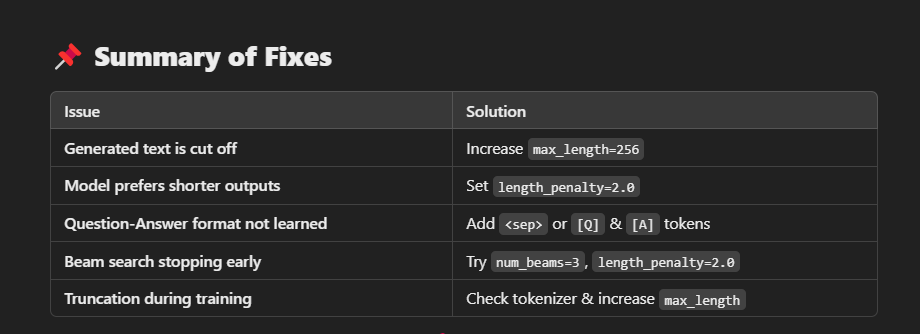

In [90]:
import torch
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score
import numpy as np

predictions = []
true_labels = []
contexts = []
device = "cuda"

for example in test_processed:
    input_ids = example["input_ids"].unsqueeze(0).to(device)
    attention_mask = example["attention_mask"].unsqueeze(0).to(device)

    # Decode the input context
    context_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    contexts.append(context_text)

    # Extract the true label (ground truth)
    true_label_ids = example["labels"]
    true_label_text = tokenizer.decode(true_label_ids, skip_special_tokens=True)
    true_labels.append(true_label_text)

    # Generate prediction
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=512,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            num_return_sequences=5,
            early_stopping=True
        )

    predicted_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)  # Try False
    predictions.append(predicted_text)

# Print some sample results
for i, (context, pred, true) in enumerate(zip(contexts[:], predictions[:], true_labels[:])):
    print(f"Example {i+1}:")
    print(f"  Context (Input): {context}")
    print(f"  Prediction: {pred}")
    print(f"  Ground Truth: {true}")
    print("------------")

# Compute BLEU score
bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_labels, predictions)]
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"BLEU Score: {average_bleu:.4f}")

# Compute ROUGE scores
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

for true, pred in zip(true_labels, predictions):
    scores = scorer.score(true, pred)
    rouge1_scores.append(scores["rouge1"].fmeasure)
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)

average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"ROUGE-1 Score: {average_rouge1:.4f}")
print(f"ROUGE-2 Score: {average_rouge2:.4f}")
print(f"ROUGE-L Score: {average_rougeL:.4f}")

# Compute F1 Score (Token-Level)
f1_scores = []
for true, pred in zip(true_labels, predictions):
    true_tokens = true.split()
    pred_tokens = pred.split()
    
    # Convert to binary labels (1 if token appears in both, else 0)
    common_tokens = set(true_tokens) & set(pred_tokens)
    
    y_true = [1 if token in common_tokens else 0 for token in true_tokens]
    y_pred = [1 if token in common_tokens else 0 for token in pred_tokens]
    
    # Ensure arrays are the same length
    min_len = min(len(y_true), len(y_pred))
    if min_len == 0:
        f1_scores.append(0)
    else:
        f1_scores.append(f1_score(y_true[:min_len], y_pred[:min_len]))

average_f1 = sum(f1_scores) / len(f1_scores)
print(f"F1 Score: {average_f1:.4f}")


Example 1:
  Context (Input): أبو القاسم محمد بن عبد الله بن عبد المطلب 22 أبريل 571 8 يونيو 632 يؤمن المسلمون بأنه رسول الله إلى الإنس والجن ليعيدهم إلى توحيد الله وعبادته شأنه شأن كل الأنبياء والمرسلين وهو خاتمهم وأرسل للناس كافة ويؤمنون أيضا بأنه أشرف المخلوقات وسيد البشر كما يعتقدون فيه العصمة
  Prediction: ما هو الرسول؟
  Ground Truth: من هو رسول الله؟ ال
------------
Example 2:
  Context (Input): أبو القاسم محمد بن عبد الله بن عبد المطلب 22 أبريل 571 8 يونيو 632 يؤمن المسلمون بأنه رسول الله إلى الإنس والجن ليعيدهم إلى توحيد الله وعبادته شأنه شأن كل الأنبياء والمرسلين وهو خاتمهم وأرسل للناس كافة ويؤمنون أيضا بأنه أشرف المخلوقات وسيد البشر كما يعتقدون فيه العصمة
  Prediction: متى ولد محمد بن عبد الله؟
  Ground Truth: لماذا يرسل الله رسوله؟ ال
------------
Example 3:
  Context (Input): أبو القاسم محمد بن عبد الله بن عبد المطلب 22 أبريل 571 8 يونيو 632 يؤمن المسلمون بأنه رسول الله إلى الإنس والجن ليعيدهم إلى توحيد الله وعبادته شأنه شأن كل الأنبياء والمرسلين وهو خاتمهم وأرسل للناس كاف

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

F1 Score: 0.3141


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics